In [13]:
%pip install qat-lang
%pip install qat-qpus
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-algorithms
%pip install numpy scipy matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement qat-qpus (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
ERROR: No matching distribution found for qat-qpus
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s  0:00:006m0:00:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler, Estimator
from qiskit.visualization import plot_histogram

%matplotlib inline


In [ ]:
# Matriz de covarianza (Colombia)
cov = np.array([
 [5.584847e-04, 4.493878e-07, -1.042715e-06, 9.843839e-06, 2.336794e-05],
 [4.493878e-07, 3.577044e-04,  2.218704e-06, 1.073661e-04, 6.415186e-05],
 [-1.042715e-06, 2.218704e-06, 2.000226e-04, 1.000010e-05, 2.000002e-06],
 [9.843839e-06, 1.073661e-04, 1.000010e-05, 2.000278e-04, 8.900089e-05],
 [2.336794e-05, 6.415186e-05, 2.000002e-06, 8.900089e-05, 2.000273e-04]
])

# retornos
mu = np.array([0.051466, 0.004144, 0.007377, -0.034193, -0.018290])

q = 0.373659   # riesgo máximo observado 
B = 2          # escoger 2 activos
lamb = 1
num_assets = len(mu)


In [65]:
from itertools import combinations

# Vector binario X = [x1..x5]
def qubo_energy(x):
    # lineal
    E = mu @ x
    
    # cuadrático
    for i,j in combinations(range(num_assets), 2):
        E -= q * cov[i,j] * x[i] * x[j]
        
    # penalización por número de activos
    E -= lamb * (B - np.sum(x))**2
    
    return E


In [66]:
def qubo_to_ising(mu, cov, q, B, lamb):
    h = np.zeros(num_assets)
    J = {}

    # Terminos lineales
    for i in range(num_assets):
        h[i] += -mu[i]/2
        h[i] += lamb * (2*B - 1)

    # Terminos cuadráticos
    for i,j in combinations(range(num_assets), 2):
        Jij = q * cov[i,j] / 4 + lamb
        J[(i,j)] = Jij

        h[i] += q * cov[i,j]/4
        h[j] += q * cov[i,j]/4

    return h, J

h, J = qubo_to_ising(mu, cov, q, B, lamb)
h, J


(array([2.97427005, 2.99794427, 2.99631273, 3.0171167 , 3.00916168]),
 {(0, 1): np.float64(1.000000041979449),
  (0, 2): np.float64(0.9999999025950389),
  (0, 3): np.float64(1.0000009195597592),
  (0, 4): np.float64(1.0000021829102732),
  (1, 2): np.float64(1.0000002072596794),
  (1, 3): np.float64(1.00001002957739),
  (1, 4): np.float64(1.000005992729964),
  (2, 3): np.float64(1.0000009341568414),
  (2, 4): np.float64(1.0000001868296868),
  (3, 4): np.float64(1.000008313995889)})

In [69]:
def gamma_op(gamma):
    qc = QuantumCircuit(num_assets)
    
    # Términos Z_i Z_j
    for (i,j), Jij in J.items():
        qc.cx(i,j)
        qc.rz(2 * gamma * Jij, j)
        qc.cx(i,j)

    # Términos Z_i
    for i in range(num_assets):
        qc.rz(2 * gamma * h[i], i)

    return qc


In [70]:
def beta_op(beta):
    qc = QuantumCircuit(num_assets)
    
    for i in range(num_assets):
        qc.ry(2 * beta, i)

    for i in range(num_assets - 1):
        qc.cx(i, i+1)
    qc.cx(num_assets-1, 0)

    for i in range(num_assets):
        qc.ry(2 * beta, i)

    return qc


In [71]:
def variational_circuit(gammas, betas):
    qc = QuantumCircuit(num_assets)
    
    # Estado inicial |+>^n
    for i in range(num_assets):
        qc.h(i)
    
    # Aplicar capas
    for g, b in zip(gammas, betas):
        qc.append(gamma_op(g).to_gate(), range(num_assets))
        qc.append(beta_op(b).to_gate(), range(num_assets))

    return qc


In [72]:
def energy_from_counts(counts):
    E = 0
    shots = sum(counts.values())

    for bitstring, count in counts.items():
        x = np.array([int(b) for b in bitstring[::-1]])  # Qiskit orden inverso
        E += qubo_energy(x) * count/shots
        
    return E


In [47]:
from qiskit import QuantumCircuit
# Visualización del circuito

num_assets = 5

# matriz para saber qué coeficiente cuadrático corresponde a (i,j)
pair_to_index = {}
idx = 5  # los primeros 5 son lineales
for i in range(num_assets):
    for j in range(i+1, num_assets):
        pair_to_index[(i,j)] = idx
        idx += 1

def gamma_op(gamma):
    num_q = num_assets
    qc_gamma = QuantumCircuit(num_q)

    # operador gamma (términos Ising Z_i Z_j)
    for i in range(num_q):
        for j in range(i+1, num_q):

            coef_ij = coefs[pair_to_index[(i,j)]]

            qc_gamma.cx(i, j)
            qc_gamma.rz(gamma * coef_ij, j)   # EXACTO como el paper
            qc_gamma.cx(i, j)

    qc_gamma.barrier()

    # términos lineales
    for i in range(num_q):
        qc_gamma.rz(coefs[i], i)

    return qc_gamma

guess = 0
gamma_op(guess).draw(fold=-1)

░ ┌──────────────┐
q_0: ──■─────────────■────■─────────────■────■──────────────────────■─────────■──────────────────────■───────────────────────────────────────────────────────────────────────────────░─┤ Rz(-0.47427) ├
     ┌─┴─┐┌───────┐┌─┴─┐  │             │    │                      │         │                      │                                                                               ░ ├──────────────┤
q_1: ┤ X ├┤ Rz(0) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼────■────┼──────■───────────────┼────■────■──────────────────────■──────────────────────────────────────────────░─┤ Rz(-0.49794) ├
     └───┘└───────┘└───┘┌─┴─┐┌───────┐┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │      │               │    │    │                      │                                              ░ ├──────────────┤
q_2: ───────────────────┤ X ├┤ Rz(0) ├┤ X ├──┼────┤ X ├──┤ Rz(0) ├──┼──┤ X ├──┼──────┼───────────────┼────┼────┼──────■───────────────┼────■────■─────────────■──────────────────────░─┤ Rz(-0.49631) ├
                        └───┘└───────┘└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │             │                      ░ ├──────────────┤
q_3: ──────────────────────────────────────┤ X ├┤ Rz(0) ├─────────┤ X ├───────┼────┤ X ├──┤ Rz(0) ├──┼──┤ X ├──┼────┤ X ├──┤ Rz(0) ├──┼──┤ X ├──┼─────────────┼────■─────────────■───░─┤ Rz(-0.51712) ├
                                           └───┘└───────┘         └───┘     ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐ ░ ├──────────────┤
q_4: ───────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(0) ├─────────┤ X ├─────┤ X ├┤ Rz(0) ├─────────┤ X ├─────┤ X ├┤ Rz(0) ├┤ X ├┤ X ├┤ Rz(0) ├┤ X ├─░─┤ Rz(-0.50916) ├
                                                                            └───┘└───────┘         └───┘     └───┘└───────┘         └───┘     └───┘└───────┘└───┘└───┘└───────┘└───┘ ░ └──────────────┘

In [54]:
num_assets = 5
num_qubits = num_assets
num_layers = 10
gamma_size = num_layers
beta_size  = num_layers

In [55]:
def energy(x):
    x = np.array(x, dtype=float)

    # término lineal EXACTO como en el paper
    term1 = (
        mu[0]*x[0] +
        mu[1]*x[1] +
        mu[2]*x[2] +
        mu[3]*x[3] +
        mu[4]*x[4]
    )

    # término cuadrático EXACTO siguiendo la forma del paper (i<j)
    term2 = q * (
        cov[0][1]*x[0]*x[1] +
        cov[0][2]*x[0]*x[2] +
        cov[0][3]*x[0]*x[3] +
        cov[0][4]*x[0]*x[4] +
        cov[1][2]*x[1]*x[2] +
        cov[1][3]*x[1]*x[3] +
        cov[1][4]*x[1]*x[4] +
        cov[2][3]*x[2]*x[3] +
        cov[2][4]*x[2]*x[4] +
        cov[3][4]*x[3]*x[4]
    )

    # penalización EXACTA
    term3 = lamb * (B - (x[0] + x[1] + x[2] + x[3] + x[4]))**2

    # HAMILTONIANO EXACTO DEL PAPER
    H = -(term1 - term2 - term3)

    return H


In [56]:
energies=[]
bitstrings=[]
for n in range(32):
    x=[(n>>i)&1 for i in range(5)]
    e=energy(x)
    energies.append(e)
    bitstrings.append(x)

idx_min=np.argmin(energies)
energies[idx_min], bitstrings[idx_min]

(np.float64(-0.058843389619844186), [1, 0, 1, 0, 0])

In [57]:
from qiskit_aer.primitives import Sampler
sampler = Sampler()

def cost_function(param):
    # Separar parámetros gamma y beta
    half = len(param) // 2
    gamma = param[:half]
    beta  = param[half:]

    # Construir circuito variacional (sin medir)
    qc = var_circuit_qiskit(gamma, beta, num_layers, num_qubits)

    # Para sampler necesitamos medir
    measure_qc = qc.copy()
    measure_qc.measure(range(num_qubits), range(num_qubits))

    # Ejecutar circuito
    result = sampler.run(measure_qc).result()
    dist = result.quasi_dists[0]   # dict: {estado: prob}

    exp_value = 0

    # EXACTAMENTE igual al paper
    for outcome, prob in dist.items():

        # outcome es un entero: lo pasamos a lista binaria (orden sin invertir)
        x = [(outcome >> i) & 1 for i in range(num_qubits)]

        # energía EXACTA del paper
        H = energy(x)

        exp_value += H * prob

    return exp_value


In [58]:
cost_function(np.zeros(2*num_layers))

np.float64(1.5345145453392242)

In [59]:
import scipy.optimize

optimal_state = "10100"       
optimal_index = int(optimal_state, 2)

n = 2                     # media de los 2 mejores valores
num_seeds = 5             # repetir optimización 5 veces
num_try = 21              # número de capas: 0..20

Hmin_med = []             # energía mínima promedio
prob_opt_med = []         # probabilidad óptima promedio
matriz_Hmin = []          
matriz_prob_opt = []      

for k in range(num_try):    
    num_layers = k

    # Caso p=0 (no hay parámetros)
    if num_layers == 0:
        H0 = cost_function(np.zeros(1))   # equivalente al paper
        print(f"Capas = 0 | <H> = {H0:.6f}")
        
        Hmin_med.append(H0)
        prob_opt_med.append(1/(2**num_qubits))
        matriz_Hmin.append([H0])
        matriz_prob_opt.append([1/(2**num_qubits)])
        continue

    Hmin = []
    prob_opt = []
    
    for i in range(num_seeds):

        np.random.seed(i**2)

        # *** EXACTAMENTE COMO EL PAPER ***
        # 2*p + 1 parámetros
        guess = np.random.random(2*num_layers + 1)

        ret = scipy.optimize.minimize(
            cost_function,
            guess,
            method='COBYLA',
            options={'maxiter': 1000, 'disp': False}
        )

        Hmin.append(ret.fun)

        # reconstruir parámetros óptimos
        half = (len(ret.x) - 1) // 2
        gamma = ret.x[:half]
        beta  = ret.x[half:-1]

        # construir circuito
        qc = var_circuit_qiskit(gamma, beta, num_layers, num_qubits)

        # medir como en el paper
        measure_qc = qc.copy()
        measure_qc.measure_all()

        result = sampler.run(measure_qc).result()
        dist = result.quasi_dists[0]

        # probabilidad del estado óptimo |10100>
        p_opt = dist.get(optimal_index, 0.0)
        prob_opt.append(p_opt)

    # promedios como en el paper
    mean_H = np.mean(sorted(Hmin)[:n])
    mean_p = np.mean(sorted(prob_opt)[-n:])

    print(f"Capas = {k:2d} | <H>min media: {mean_H:.6f} | Prob(|10100>): {mean_p:.6f}")

    Hmin_med.append(mean_H)
    prob_opt_med.append(mean_p)
    matriz_Hmin.append(Hmin)
    matriz_prob_opt.append(prob_opt)


Capas = 0 | <H> = 1.602192
Capas =  1 | <H>min media: 1.258853 | Prob(|10100>): 0.000000
Capas =  2 | <H>min media: 0.387404 | Prob(|10100>): 0.000000
Capas =  3 | <H>min media: 0.727006 | Prob(|10100>): 0.000000
Capas =  4 | <H>min media: 0.698766 | Prob(|10100>): 0.000000
Capas =  5 | <H>min media: 0.573768 | Prob(|10100>): 0.000000
Capas =  6 | <H>min media: 0.532373 | Prob(|10100>): 0.000000
Capas =  7 | <H>min media: 0.604806 | Prob(|10100>): 0.000000
Capas =  8 | <H>min media: 0.644046 | Prob(|10100>): 0.000000
Capas =  9 | <H>min media: 0.631096 | Prob(|10100>): 0.000000
Capas = 10 | <H>min media: 0.647951 | Prob(|10100>): 0.000000
Capas = 11 | <H>min media: 0.538118 | Prob(|10100>): 0.000000
Capas = 12 | <H>min media: 0.502870 | Prob(|10100>): 0.000000
Capas = 13 | <H>min media: 0.438109 | Prob(|10100>): 0.000000
Capas = 14 | <H>min media: 0.399027 | Prob(|10100>): 0.000000
Capas = 15 | <H>min media: 0.481708 | Prob(|10100>): 0.000000
Capas = 16 | <H>min media: 0.453829 | Prob(

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (32,) and arg 1 with shape (5,).

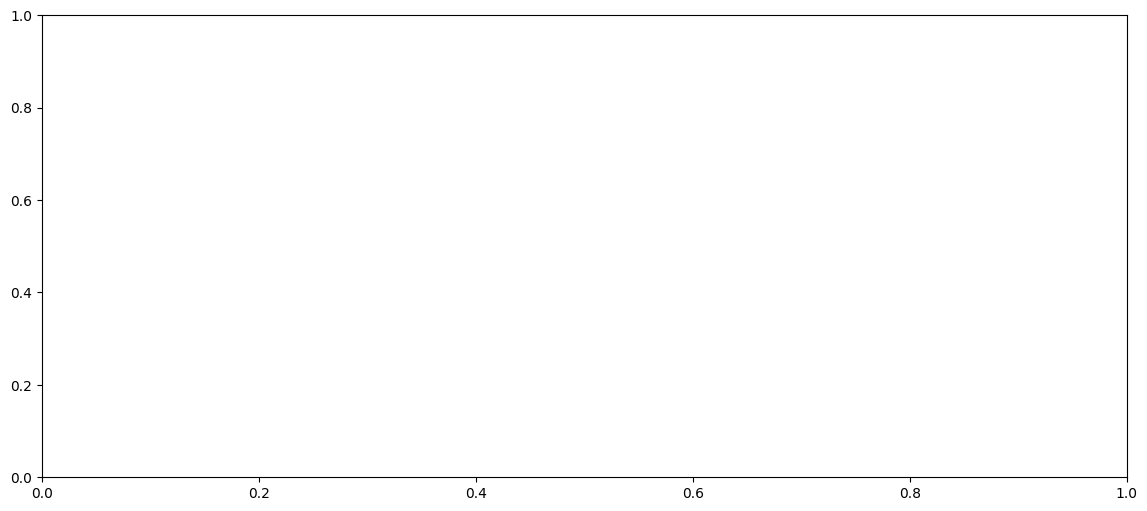

In [63]:
# Plot da distribuição de probabilidades para 5 qubits

# Todos os 32 estados possíveis (5 qubits)
strings = [
    '00000','00001','00010','00011',
    '00100','00101','00110','00111',
    '01000','01001','01010','01011',
    '01100','01101','01110','01111',
    '10000','10001','10010','10011',
    '10100','10101','10110','10111',
    '11000','11001','11010','11011',
    '11100','11101','11110','11111'
]

# probs debe ser una lista de 32 probabilidades en el mismo orden
x = np.arange(len(strings))
width = 0.9

plt.figure(figsize=(14,6))
plt.bar(x, prob_opt, width=width, color='black')
plt.xlabel('Autoestado', size=14)
plt.ylabel('Probabilidade', size=14)
plt.title('Distribuição de Probabilidades (5 qubits)', size=16)
plt.xticks(x, strings, rotation=90)
plt.tight_layout()
plt.show()
